# Scene text detection

### Imports and data loading

In [127]:
import random
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pytesseract
import keras_ocr
# import easyocr

from pytesseract import Output
from shapely import Polygon, intersection
from glob import glob
from PIL import Image

plt.style.use('ggplot')
comparison_data_path = 'C:/Users/Nadia Timoleon/Documents/'

# pytesseract settings
tesseract_path = r'C:\Users\Nadia Timoleon\AppData\Local\Programs\Tesseract-OCR\tesseract.exe'
pytesseract.pytesseract.tesseract_cmd = tesseract_path

# kerasocr pipeline
keras_ocr_pipeline = keras_ocr.pipeline.Pipeline()

# Load image data & annotations
annot = pd.read_parquet(comparison_data_path + 'comparison-data/annot.parquet')
annot_agg = annot[['image_id','utf8_string']].groupby(['image_id'], as_index=False).agg({'utf8_string': ' '.join})
imgs = pd.read_parquet(comparison_data_path + 'comparison-data/img.parquet')
img_fns = glob(comparison_data_path + 'comparison-data/train_images/*')

Looking for C:\Users\Nadia Timoleon\.keras-ocr\craft_mlt_25k.h5
Looking for C:\Users\Nadia Timoleon\.keras-ocr\crnn_kurapan.h5


### Functions for easier calculations and plotting

In [157]:
# Function to get top left coordinates of detected_bbox, to write text
def get_coords_for_text(bbox):
    x = bbox[0][0]
    y = bbox[0][1]
    return x, y


# Function to extract x and y coordinates from detected bbox
def get_detected_bbox_coords(detected_bbox):
    # ONLY for easyocr and keras-ocr
    x1, y1 = detected_bbox[0][0], detected_bbox[0][1]
    x2, y2 = detected_bbox[1][0], detected_bbox[1][1]
    x3, y3 = detected_bbox[2][0], detected_bbox[2][1]
    x4, y4 = detected_bbox[3][0], detected_bbox[3][1]
    # top left -> top right -> bottom right -> bottom left
    return (x1, x2, x3, x4), (y1, y2, y3, y4)


def get_annot_bbox_coords(annot_bbox):
    x1, y1 = annot_bbox[0], annot_bbox[1], 
    x2, y2 = annot_bbox[2], annot_bbox[3]
    x3, y3 = annot_bbox[4], annot_bbox[5]
    x4, y4 = annot_bbox[6], annot_bbox[7]
    # top left -> top right -> bottom right -> bottom left
    return (x1, x2, x3, x4), (y1, y2, y3, y4)


# Draw detected text to given plot
# ONLY for easyocr and keras-ocr
def add_detected_text(detected_text, ax):
    for _, row in detected_text.iterrows():
        x, y = get_coords_for_text(row['bbox'])
        text = row['text']
        ax.annotate(text, (x, y), fontsize=11, color='red')


# Draw ground truth bounding boxes to given plot
def draw_gt_bbox(image_annot, ax):
    for _, row in image_annot.iterrows():
        bbox = row['bbox']
        rectangle = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=2, edgecolor='green', facecolor='none')
        ax.add_patch(rectangle)


# Draw detected bounding boxes to given plot
# ONLY for easyocr and keras-ocr
def draw_detected_bbox(detected_text, ax, color='red'):
    for _, row in detected_text.iterrows():
        xs, ys = get_detected_bbox_coords(row['bbox'])
        xplot = np.append(np.array(xs), xs[0])
        yplot = np.append(np.array(ys), ys[0])
        ax.plot(xplot, yplot, color)


def build_bbox_polygon(bbox, get_coords_method):
    x, y = get_coords_method(bbox)
    return Polygon([(x,y) for x,y in zip(x,y)])


def calculate_intersection_of_union(pol1, pol2):
    numerator = intersection(pol1, pol2).area
    denominator = pol1.area + pol2.area - numerator
    return numerator/denominator


def find_closest_bbox(annot_bbox, candinate_bboxes, distance_threshold=0.5):
    min_distance = distance_threshold
    closest_bbox = None
    # Iterate through candidate bboxes and find the one with minimum distance
    for cand in candinate_bboxes:
        distance = annot_bbox.distance(cand)
        if distance < min_distance:
            closest_bbox = cand
    return closest_bbox


def pytesseract_text_detection(images):
    pytesseract_detected_text = pd.DataFrame(columns=['image_id', 'text','left','top','width','height', 'bbox_polygon'])
    for image in tqdm(images, desc="Processing Images", ncols=100):
        image_id = image.split('/')[-1].split('\\')[-1].rstrip('.jpg')
        df = pytesseract.image_to_data(image, output_type=Output.DATAFRAME)
        df.loc[:, 'image_id'] = image_id
        df = df[df.text!=' '].dropna()
        df['bbox_polygon'] = [
            Polygon([(row['left'], row['top']),
                    (row['left'] + row['width'], row['top']),
                    (row['left'] + row['width'], row['top'] + row['height']),
                    (row['left'], row['top'] + row['height'])])
            for _, row in df.iterrows()]
        df1 = df[['image_id', 'text','left','top','width','height', 'bbox_polygon']]
        pytesseract_detected_text = pd.concat([pytesseract_detected_text, df1])
    return pytesseract_detected_text


def easyocr_text_detection(images):
    easyocr_detected_text = pd.DataFrame(columns=['image_id', 'text', 'bbox', 'bbox_polygon'])
    for img in tqdm(images, desc="Processing Images", ncols=100):
        image_id = img.split('/')[-1].split('\\')[-1].rstrip('.jpg')
        df = pd.DataFrame(easy_ocr_reader.readtext(img), columns=['bbox','text','confidence'])[['text','bbox']]
        df1 = pd.DataFrame({
            'text': df['text'],
            'bbox': df['bbox']
        })
        df1['bbox_polygon'] = [
            build_bbox_polygon(row['bbox'], get_detected_bbox_coords)
        for _, row in df1.iterrows()]
        df1['image_id'] = image_id
        df1 = df1[df1.text!=' '].dropna()
        easyocr_detected_text = pd.concat([easyocr_detected_text, df1])
    return easyocr_detected_text


def kerasocr_text_detection(images):
    kerasocr_detected_text = pd.DataFrame(columns=['image_id', 'text', 'bbox', 'bbox_polygon'])
    for image in tqdm(images, desc="Processing Images", ncols=100):
        image_id = image.split('/')[-1].split('\\')[-1].rstrip('.jpg')
        result = keras_ocr_pipeline.recognize([keras_ocr.tools.read(image)])
        text = [i[0] for i in result[0]]
        bbox = [i[1] for i in result[0]]
        df = pd.DataFrame({'image_id': image_id, 'text': text, 'bbox': bbox})
        df['bbox_polygon'] = [
            build_bbox_polygon(row['bbox'], get_detected_bbox_coords)
        for _, row in df.iterrows()]
        kerasocr_detected_text = pd.concat([kerasocr_detected_text, df])
    return kerasocr_detected_text

##### do not re run

In [3]:
# add bbox polygons to annotations
# annot_poly = annot.copy()
# annot_poly['bbox_polygon'] = annot_poly.apply(lambda row : build_bbox_polygon(row['points'], get_annot_bbox_coords), axis = 1)
# annot_poly.to_pickle("./annot_poly.pkl")
annot_poly = pd.read_pickle("./annot_poly.pkl")  

### Method testing

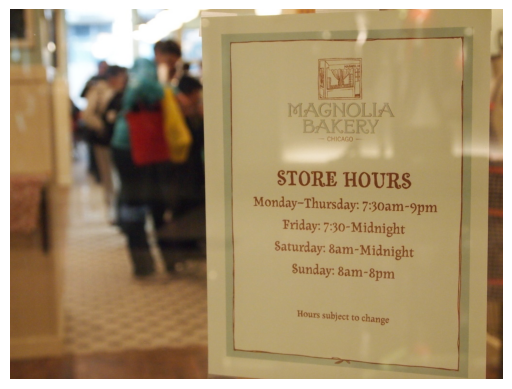

In [52]:
image = comparison_data_path + 'comparison-data/train_images\\000bb81adefe7332.jpg'
# image = random.choice(img_fns)
image_id = image.split('/')[-1].split('\\')[-1].rstrip('.jpg')
image_annot = annot[annot['image_id']==image_id]

img = Image.open(image)
fig, ax = plt.subplots()
ax.imshow(img)
plt.axis('off')
plt.show()

#### 1. pytesseract

Processing Images: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s]


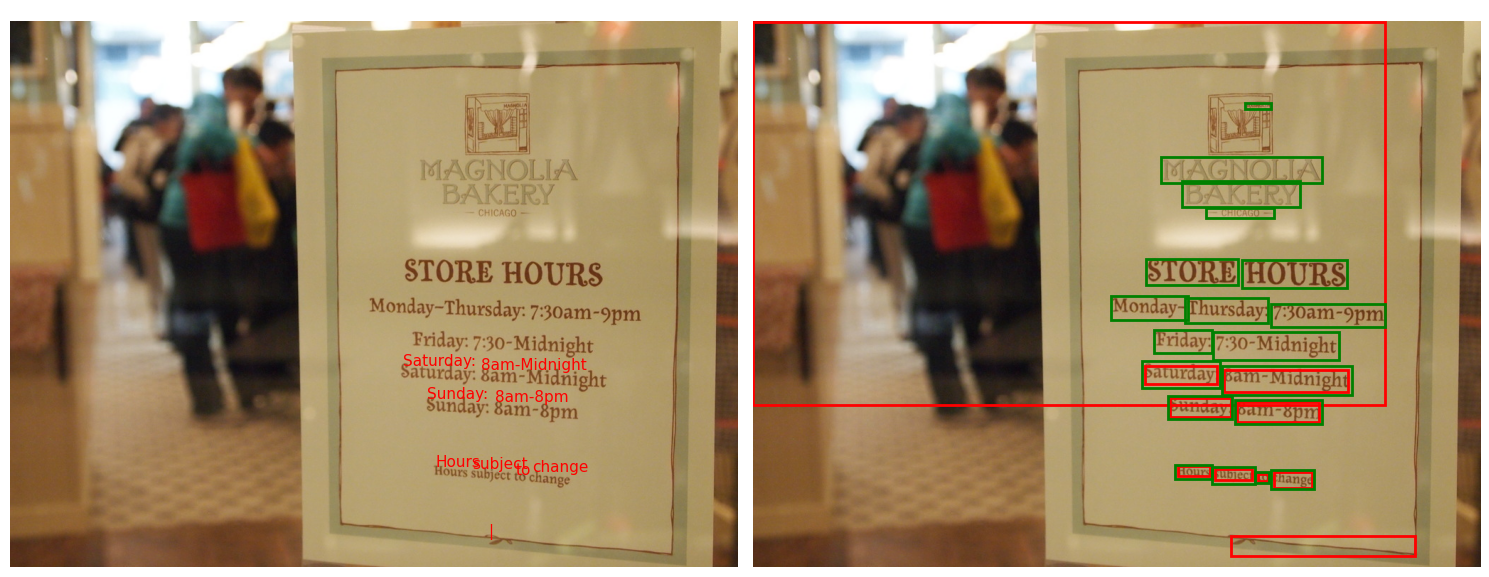

In [59]:
pytesseract_sample = pytesseract_text_detection([image])

# Plot detected text on image
img = Image.open(image)
fig, ax = plt.subplots(1, 2, figsize=(15, 30))
ax[0].imshow(img)
ax[0].axis('off')
ax[1].imshow(img)
ax[1].axis('off')

# Iterate through the DataFrame and add text annotations
for index, row in pytesseract_sample.iterrows():
    x, y = row['left'], row['top']
    text = row['text']
    ax[0].annotate(text, (x, y), fontsize=11, color='red')
    rectangle = patches.Rectangle((row['left'], row['top']), row['width'], row['height'], linewidth=2, edgecolor='red', facecolor='none')
    ax[1].add_patch(rectangle)

draw_gt_bbox(image_annot, ax[1])

# Remove axis and show the plot
fig.tight_layout()
plt.show()

#### 2. easyocr

Using CPU. Note: This module is much faster with a GPU.


Processing Images: 100%|██████████████████████████████████████████████| 1/1 [00:06<00:00,  6.79s/it]


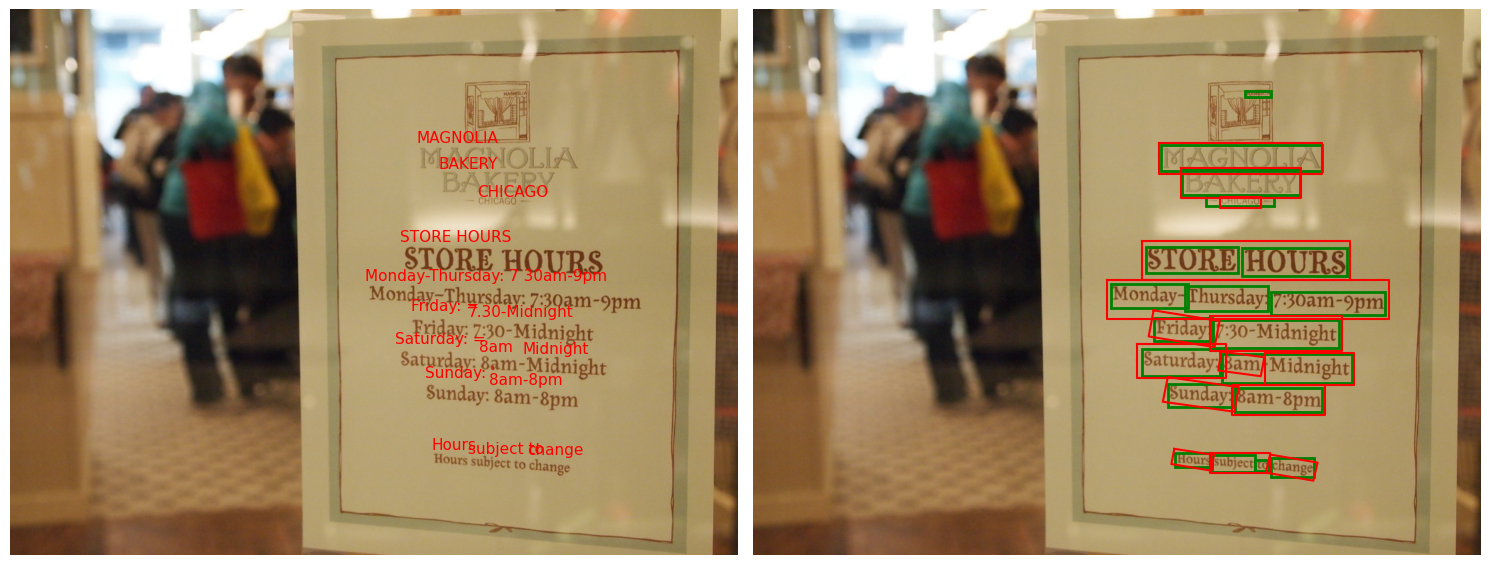

In [60]:
import easyocr
# easyocr reader
easy_ocr_reader = easyocr.Reader(['en'], gpu = False)
easyocr_sample = easyocr_text_detection([image])

# Plot detected text on image
img = Image.open(image)
fig, ax = plt.subplots(1, 2, figsize=(15, 30))
ax[0].imshow(img)
ax[0].axis('off')
ax[1].imshow(img)
ax[1].axis('off')

add_detected_text(easyocr_sample, ax[0])
draw_detected_bbox(easyocr_sample, ax[1])
draw_gt_bbox(image_annot, ax[1])

# Remove axis and show the plot
fig.tight_layout()
plt.show()

#### 3. keras_ocr

Processing Images:   0%|                                                      | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 8s 8s/step


Processing Images: 100%|██████████████████████████████████████████████| 1/1 [00:35<00:00, 35.94s/it]


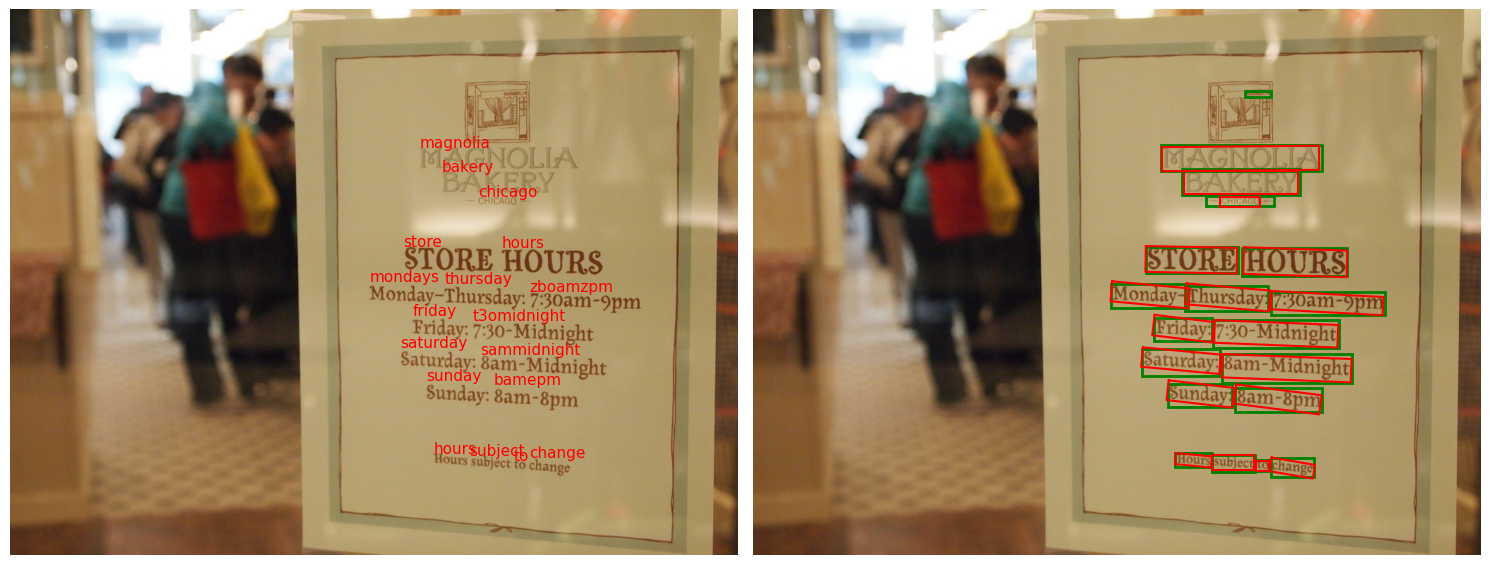

In [61]:
kerasocr_sample = kerasocr_text_detection([image])

# Plot detected text on image
img = Image.open(image)
fig, ax = plt.subplots(1, 2, figsize=(15, 30))
ax[0].imshow(img)
ax[0].axis('off')
ax[1].imshow(img)
ax[1].axis('off')

add_detected_text(kerasocr_sample, ax[0])
draw_detected_bbox(kerasocr_sample, ax[1])
draw_gt_bbox(image_annot, ax[1])

# Remove axis and show the plot
fig.tight_layout()
plt.show()

### Method comparison

##### Run all methods on multiple images

In [132]:
n = 100
test_images = random.sample(img_fns, n)
test_images_ids = [i.split('/')[-1].split('\\')[-1].rstrip('.jpg') for i in test_images]
test_images_annot = annot_poly[annot_poly['image_id'].isin(test_images_ids)]

print("Running text detection with pytesseract")
pytesseract_detected_text = pytesseract_text_detection(test_images)
print("Pickling results")
pytesseract_detected_text.to_pickle("./pytesseract_detected_text.pkl")
print("Pickled!")
print("-----------------------------------------")
print("Running text detection with easyocr")
easyocr_detected_text = easyocr_text_detection(test_images)
print("Pickling results")
easyocr_detected_text.to_pickle("./easyocr_detected_text.pkl")
print("Pickled!")
print("-----------------------------------------")
print("Running text detection with keras-ocr")
kerasocr_detected_text = kerasocr_text_detection(test_images)
print("Pickling results")
kerasocr_detected_text.to_pickle("./kerasocr_detected_text.pkl")
print("Pickled!")

Running text detection with pytesseract


Processing Images: 100%|██████████████████████████████████████████| 100/100 [00:25<00:00,  4.00it/s]


Pickling results
Pickled!
-----------------------------------------
Running text detection with easyocr


Processing Images: 100%|██████████████████████████████████████████| 100/100 [09:33<00:00,  5.74s/it]


Pickling results
Pickled!
-----------------------------------------
Running text detection with keras-ocr


Processing Images:   0%|                                                    | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 3s 3s/step


Processing Images:   1%|▍                                           | 1/100 [00:15<25:26, 15.42s/it]

1/1 [==============================] - 0s 386ms/step


Processing Images:   2%|▉                                           | 2/100 [00:32<26:47, 16.41s/it]

1/1 [==============================] - 1s 655ms/step


Processing Images:   3%|█▎                                          | 3/100 [00:51<28:20, 17.53s/it]

1/1 [==============================] - 0s 386ms/step


Processing Images:   4%|█▊                                          | 4/100 [01:07<27:18, 17.07s/it]

1/1 [==============================] - 2s 2s/step


Processing Images:   5%|██▏                                         | 5/100 [01:34<32:22, 20.45s/it]

2/2 [==============================] - 3s 119ms/step


Processing Images:   6%|██▋                                         | 6/100 [01:53<31:34, 20.15s/it]

1/1 [==============================] - 1s 1s/step


Processing Images:   7%|███                                         | 7/100 [02:13<30:53, 19.93s/it]

2/2 [==============================] - 5s 1s/step


Processing Images:   8%|███▌                                        | 8/100 [02:36<32:01, 20.89s/it]

1/1 [==============================] - 2s 2s/step


Processing Images:   9%|███▉                                        | 9/100 [02:54<30:16, 19.96s/it]

1/1 [==============================] - 1s 1s/step


Processing Images:  10%|████▎                                      | 10/100 [03:13<29:47, 19.86s/it]

1/1 [==============================] - 0s 132ms/step


Processing Images:  11%|████▋                                      | 11/100 [03:30<27:52, 18.80s/it]

1/1 [==============================] - 1s 743ms/step


Processing Images:  12%|█████▏                                     | 12/100 [03:44<25:26, 17.35s/it]

1/1 [==============================] - 1s 563ms/step


Processing Images:  13%|█████▌                                     | 13/100 [04:02<25:44, 17.75s/it]

1/1 [==============================] - 0s 382ms/step


Processing Images:  14%|██████                                     | 14/100 [04:21<25:45, 17.97s/it]

1/1 [==============================] - 0s 301ms/step


Processing Images:  15%|██████▍                                    | 15/100 [04:37<24:48, 17.51s/it]

1/1 [==============================] - 2s 2s/step


Processing Images:  16%|██████▉                                    | 16/100 [04:56<24:53, 17.79s/it]

2/2 [==============================] - 4s 854ms/step


Processing Images:  17%|███████▎                                   | 17/100 [05:16<25:28, 18.42s/it]

1/1 [==============================] - 2s 2s/step


Processing Images:  18%|███████▋                                   | 18/100 [05:36<26:04, 19.08s/it]

1/1 [==============================] - 0s 212ms/step


Processing Images:  19%|████████▏                                  | 19/100 [05:54<25:17, 18.73s/it]

1/1 [==============================] - 2s 2s/step


Processing Images:  20%|████████▌                                  | 20/100 [06:14<25:18, 18.98s/it]

1/1 [==============================] - 1s 558ms/step


Processing Images:  21%|█████████                                  | 21/100 [06:33<25:03, 19.03s/it]

1/1 [==============================] - 1s 1s/step


Processing Images:  22%|█████████▍                                 | 22/100 [06:47<22:43, 17.48s/it]

2/2 [==============================] - 5s 2s/step


Processing Images:  23%|█████████▉                                 | 23/100 [07:09<24:21, 18.98s/it]

1/1 [==============================] - 1s 1s/step


Processing Images:  24%|██████████▎                                | 24/100 [07:28<24:05, 19.01s/it]

1/1 [==============================] - 0s 214ms/step


Processing Images:  25%|██████████▊                                | 25/100 [07:49<24:33, 19.65s/it]

1/1 [==============================] - 2s 2s/step


Processing Images:  26%|███████████▏                               | 26/100 [08:02<21:35, 17.51s/it]

12/12 [==============================] - 33s 3s/step


Processing Images:  27%|███████████▌                               | 27/100 [08:53<33:30, 27.54s/it]

2/2 [==============================] - 5s 2s/step


Processing Images:  28%|████████████                               | 28/100 [09:15<30:57, 25.80s/it]

6/6 [==============================] - 17s 3s/step


Processing Images:  29%|████████████▍                              | 29/100 [09:50<33:58, 28.71s/it]

1/1 [==============================] - 1s 1s/step


Processing Images:  30%|████████████▉                              | 30/100 [10:07<29:22, 25.17s/it]

1/1 [==============================] - 2s 2s/step


Processing Images:  31%|█████████████▎                             | 31/100 [10:27<27:03, 23.54s/it]

1/1 [==============================] - 0s 343ms/step


Processing Images:  32%|█████████████▊                             | 32/100 [10:43<24:05, 21.26s/it]

1/1 [==============================] - 0s 211ms/step


Processing Images:  33%|██████████████▏                            | 33/100 [11:00<22:34, 20.22s/it]

1/1 [==============================] - 2s 2s/step


Processing Images:  34%|██████████████▌                            | 34/100 [11:20<22:03, 20.06s/it]

1/1 [==============================] - 2s 2s/step


Processing Images:  35%|███████████████                            | 35/100 [11:40<21:38, 19.98s/it]

5/5 [==============================] - 13s 3s/step


Processing Images:  36%|███████████████▍                           | 36/100 [12:10<24:26, 22.91s/it]

1/1 [==============================] - 0s 289ms/step


Processing Images:  37%|███████████████▉                           | 37/100 [12:27<22:25, 21.36s/it]

1/1 [==============================] - 2s 2s/step


Processing Images:  38%|████████████████▎                          | 38/100 [12:47<21:36, 20.92s/it]

1/1 [==============================] - 1s 550ms/step


Processing Images:  39%|████████████████▊                          | 39/100 [13:04<19:53, 19.56s/it]

1/1 [==============================] - 1s 827ms/step


Processing Images:  40%|█████████████████▏                         | 40/100 [13:22<19:13, 19.22s/it]

1/1 [==============================] - 0s 294ms/step


Processing Images:  41%|█████████████████▋                         | 41/100 [13:40<18:31, 18.84s/it]

1/1 [==============================] - 0s 224ms/step


Processing Images:  42%|██████████████████                         | 42/100 [13:56<17:24, 18.01s/it]

1/1 [==============================] - 1s 640ms/step


Processing Images:  43%|██████████████████▍                        | 43/100 [14:12<16:37, 17.50s/it]

1/1 [==============================] - 1s 557ms/step


Processing Images:  44%|██████████████████▉                        | 44/100 [14:29<16:03, 17.20s/it]

1/1 [==============================] - 3s 3s/step


Processing Images:  45%|███████████████████▎                       | 45/100 [14:41<14:12, 15.50s/it]

1/1 [==============================] - 1s 1s/step


Processing Images:  46%|███████████████████▊                       | 46/100 [15:00<14:53, 16.55s/it]

1/1 [==============================] - 2s 2s/step


Processing Images:  47%|████████████████████▏                      | 47/100 [15:20<15:38, 17.70s/it]

1/1 [==============================] - 1s 1s/step


Processing Images:  48%|████████████████████▋                      | 48/100 [15:33<14:14, 16.44s/it]

1/1 [==============================] - 0s 150ms/step


Processing Images:  49%|█████████████████████                      | 49/100 [15:49<13:50, 16.28s/it]

5/5 [==============================] - 13s 2s/step


Processing Images:  50%|█████████████████████▌                     | 50/100 [16:21<17:18, 20.77s/it]

1/1 [==============================] - 2s 2s/step


Processing Images:  51%|█████████████████████▉                     | 51/100 [16:39<16:21, 20.03s/it]

1/1 [==============================] - 0s 214ms/step


Processing Images:  52%|██████████████████████▎                    | 52/100 [16:55<15:06, 18.88s/it]

2/2 [==============================] - 5s 2s/step


Processing Images:  53%|██████████████████████▊                    | 53/100 [17:14<14:49, 18.94s/it]

2/2 [==============================] - 3s 120ms/step


Processing Images:  54%|███████████████████████▏                   | 54/100 [17:28<13:16, 17.32s/it]

1/1 [==============================] - 2s 2s/step


Processing Images:  55%|███████████████████████▋                   | 55/100 [17:45<13:04, 17.43s/it]

3/3 [==============================] - 6s 2s/step


Processing Images:  56%|████████████████████████                   | 56/100 [18:07<13:48, 18.82s/it]

1/1 [==============================] - 3s 3s/step


Processing Images:  57%|████████████████████████▌                  | 57/100 [18:26<13:31, 18.87s/it]

1/1 [==============================] - 2s 2s/step


Processing Images:  58%|████████████████████████▉                  | 58/100 [18:46<13:18, 19.01s/it]

1/1 [==============================] - 2s 2s/step


Processing Images:  59%|█████████████████████████▎                 | 59/100 [19:10<13:58, 20.45s/it]

1/1 [==============================] - 2s 2s/step


Processing Images:  60%|█████████████████████████▊                 | 60/100 [19:29<13:27, 20.19s/it]

1/1 [==============================] - 2s 2s/step


Processing Images:  61%|██████████████████████████▏                | 61/100 [19:45<12:17, 18.92s/it]

1/1 [==============================] - 0s 386ms/step


Processing Images:  62%|██████████████████████████▋                | 62/100 [20:01<11:29, 18.14s/it]

4/4 [==============================] - 10s 2s/step


Processing Images:  63%|███████████████████████████                | 63/100 [20:32<13:26, 21.80s/it]

1/1 [==============================] - 1s 830ms/step


Processing Images:  64%|███████████████████████████▌               | 64/100 [20:46<11:44, 19.57s/it]

2/2 [==============================] - 5s 2s/step


Processing Images:  65%|███████████████████████████▉               | 65/100 [21:09<11:59, 20.55s/it]

1/1 [==============================] - 3s 3s/step


Processing Images:  66%|████████████████████████████▍              | 66/100 [21:30<11:42, 20.66s/it]

1/1 [==============================] - 0s 466ms/step


Processing Images:  67%|████████████████████████████▊              | 67/100 [21:46<10:39, 19.37s/it]

1/1 [==============================] - 2s 2s/step


Processing Images:  68%|█████████████████████████████▏             | 68/100 [22:01<09:38, 18.06s/it]

1/1 [==============================] - 1s 545ms/step


Processing Images:  69%|█████████████████████████████▋             | 69/100 [22:17<09:00, 17.44s/it]

1/1 [==============================] - 3s 3s/step


Processing Images:  70%|██████████████████████████████             | 70/100 [22:36<08:56, 17.89s/it]

1/1 [==============================] - 1s 1s/step


Processing Images:  71%|██████████████████████████████▌            | 71/100 [22:55<08:51, 18.31s/it]

1/1 [==============================] - 2s 2s/step


Processing Images:  72%|██████████████████████████████▉            | 72/100 [23:13<08:27, 18.13s/it]

1/1 [==============================] - 1s 548ms/step


Processing Images:  73%|███████████████████████████████▍           | 73/100 [23:31<08:09, 18.14s/it]

1/1 [==============================] - 1s 646ms/step


Processing Images:  74%|███████████████████████████████▊           | 74/100 [23:50<07:52, 18.16s/it]

1/1 [==============================] - 2s 2s/step


Processing Images:  75%|████████████████████████████████▎          | 75/100 [24:07<07:31, 18.05s/it]

1/1 [==============================] - 0s 295ms/step


Processing Images:  76%|████████████████████████████████▋          | 76/100 [24:25<07:11, 17.97s/it]

1/1 [==============================] - 1s 539ms/step


Processing Images:  77%|█████████████████████████████████          | 77/100 [24:41<06:40, 17.39s/it]

1/1 [==============================] - 1s 983ms/step


Processing Images:  78%|█████████████████████████████████▌         | 78/100 [24:58<06:18, 17.19s/it]

1/1 [==============================] - 1s 887ms/step


Processing Images:  79%|█████████████████████████████████▉         | 79/100 [25:15<05:57, 17.04s/it]

1/1 [==============================] - 1s 562ms/step


Processing Images:  80%|██████████████████████████████████▍        | 80/100 [25:33<05:48, 17.43s/it]

1/1 [==============================] - 2s 2s/step


Processing Images:  81%|██████████████████████████████████▊        | 81/100 [25:52<05:43, 18.07s/it]

1/1 [==============================] - 0s 404ms/step


Processing Images:  82%|███████████████████████████████████▎       | 82/100 [26:09<05:19, 17.75s/it]

1/1 [==============================] - 1s 1s/step


Processing Images:  83%|███████████████████████████████████▋       | 83/100 [26:28<05:07, 18.07s/it]

1/1 [==============================] - 1s 553ms/step


Processing Images:  84%|████████████████████████████████████       | 84/100 [26:43<04:32, 17.03s/it]

1/1 [==============================] - 2s 2s/step


Processing Images:  85%|████████████████████████████████████▌      | 85/100 [26:54<03:49, 15.32s/it]

1/1 [==============================] - 2s 2s/step


Processing Images:  86%|████████████████████████████████████▉      | 86/100 [27:12<03:46, 16.15s/it]

2/2 [==============================] - 4s 647ms/step


Processing Images:  87%|█████████████████████████████████████▍     | 87/100 [27:32<03:43, 17.16s/it]

2/2 [==============================] - 5s 2s/step


Processing Images:  88%|█████████████████████████████████████▊     | 88/100 [27:55<03:48, 19.03s/it]

1/1 [==============================] - 1s 714ms/step


Processing Images:  89%|██████████████████████████████████████▎    | 89/100 [28:19<03:45, 20.51s/it]

1/1 [==============================] - 1s 551ms/step


Processing Images:  90%|██████████████████████████████████████▋    | 90/100 [28:37<03:16, 19.63s/it]

1/1 [==============================] - 2s 2s/step


Processing Images:  91%|███████████████████████████████████████▏   | 91/100 [28:56<02:54, 19.38s/it]

1/1 [==============================] - 0s 480ms/step


Processing Images:  92%|███████████████████████████████████████▌   | 92/100 [29:12<02:27, 18.38s/it]

1/1 [==============================] - 2s 2s/step


Processing Images:  93%|███████████████████████████████████████▉   | 93/100 [29:31<02:11, 18.78s/it]

1/1 [==============================] - 1s 1s/step


Processing Images:  94%|████████████████████████████████████████▍  | 94/100 [29:51<01:53, 18.95s/it]

1/1 [==============================] - 0s 319ms/step


Processing Images:  95%|████████████████████████████████████████▊  | 95/100 [30:09<01:33, 18.62s/it]

1/1 [==============================] - 2s 2s/step


Processing Images:  96%|█████████████████████████████████████████▎ | 96/100 [30:28<01:15, 18.80s/it]

1/1 [==============================] - 0s 217ms/step


Processing Images:  97%|█████████████████████████████████████████▋ | 97/100 [30:45<00:55, 18.45s/it]

1/1 [==============================] - 0s 461ms/step


Processing Images:  98%|██████████████████████████████████████████▏| 98/100 [31:02<00:35, 17.76s/it]

1/1 [==============================] - 2s 2s/step


Processing Images:  99%|██████████████████████████████████████████▌| 99/100 [31:19<00:17, 17.65s/it]

2/2 [==============================] - 4s 910ms/step


Processing Images: 100%|██████████████████████████████████████████| 100/100 [31:46<00:00, 19.07s/it]

Pickling results


Pickled!


##### Compare all methods to annotation using IoU (Intersection of Union)

In [153]:
method_comparison = pd.DataFrame(columns=['image_id', 'pytesseract', 'easyocr', 'kerasocr'])
distance_threshold = 20

for _, row in test_images_annot.iterrows():
    image_id = row['image_id']
    annot_bbox = row['bbox_polygon']
    try:
        pytesseract_bbox = find_closest_bbox(
            annot_bbox,
            pytesseract_detected_text[pytesseract_detected_text['image_id']==image_id]['bbox_polygon'],
            distance_threshold
            )
        pytesseract_IoU = calculate_intersection_of_union(annot_bbox, pytesseract_bbox)
    except:
        pytesseract_IoU = 0
    try:
        easyocr_bbox = find_closest_bbox(
            annot_bbox,
            easyocr_detected_text[easyocr_detected_text['image_id']==image_id]['bbox_polygon'],
            distance_threshold
        )
        easyocr_IoU = calculate_intersection_of_union(annot_bbox, easyocr_bbox)
    except:
        easyocr_IoU = 0
    try:
        kerasocr_bbox = find_closest_bbox(
            annot_bbox,
            kerasocr_detected_text[kerasocr_detected_text['image_id']==image_id]['bbox_polygon'],
            distance_threshold
        )
        kerasocr_IoU = calculate_intersection_of_union(annot_bbox, kerasocr_bbox)
    except:
        kerasocr_IoU = 0
    df = pd.DataFrame({'image_id': image_id,
                       'pytesseract': pytesseract_IoU,
                       'easyocr': easyocr_IoU,
                       'kerasocr': kerasocr_IoU}, index=[0])
    method_comparison = pd.concat([method_comparison, df])

method_comparison.to_pickle("./method_comparison.pkl")

c:\Users\Nadia Timoleon\anaconda3\envs\tensorflow\Lib\site-packages\shapely\measurement.py:74: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)


In [165]:
print("Compute average IoU scores for each method")
print("------------------------------------------")
print("Pytesseract: ", round(sum(method_comparison['pytesseract'])/len(method_comparison), 3))
print("EasyOCR: ", round(sum(method_comparison['easyocr'])/len(method_comparison), 3))
print("Keras-OCR: ", round(sum(method_comparison['kerasocr'])/len(method_comparison), 3))

Compute average IoU scores for each method
------------------------------------------
Pytesseract:  0.012
EasyOCR:  0.084
Keras-OCR:  0.097


##### Plot bboxes from all methods on a subset of the test images

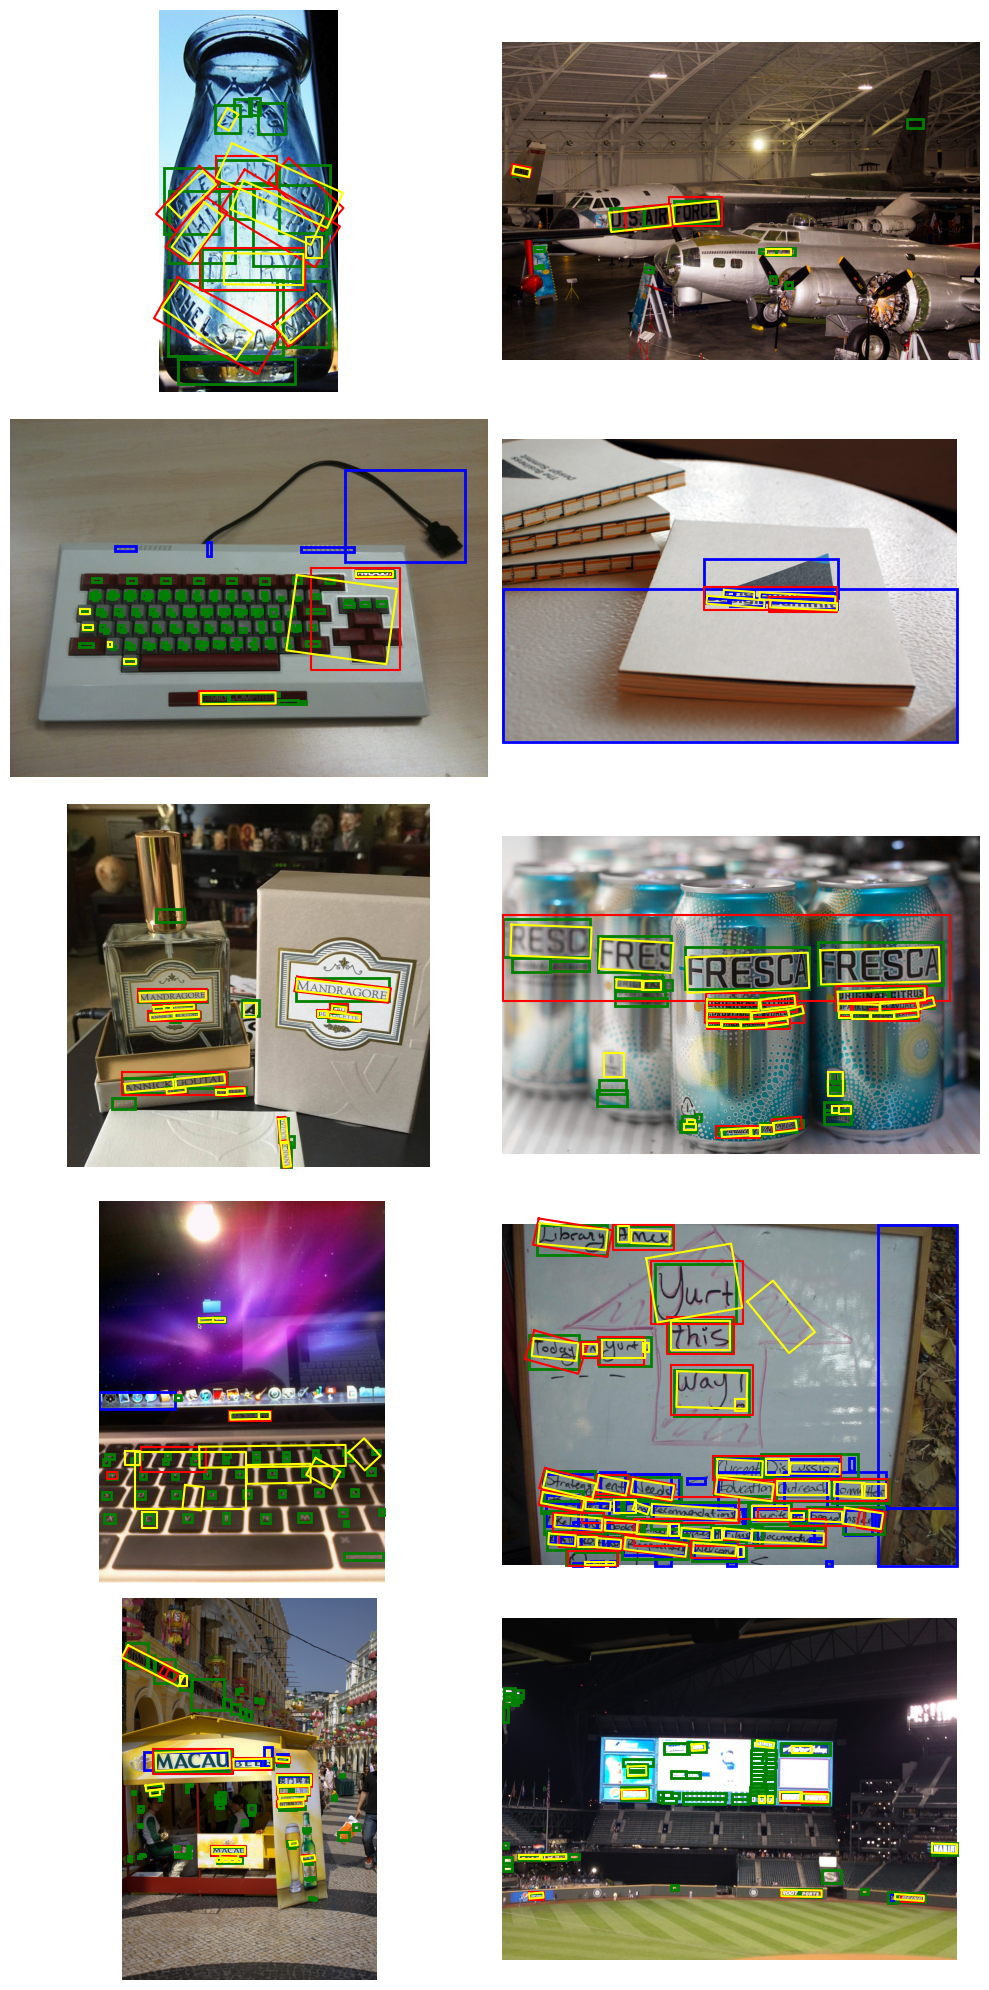

In [163]:
# Plot detected text on image
fig, axs = plt.subplots(5, 2, figsize=(10, 20))
for i, ax in enumerate(axs.flat):
    image = test_images[i]
    img = Image.open(image)
    img_id = image.split('/')[-1].split('\\')[-1].rstrip('.jpg')
    img_annot = annot[annot['image_id']==img_id]
    ax.imshow(img)
    ax.axis('off')

    pytesseract = pytesseract_detected_text[pytesseract_detected_text['image_id']==img_id]
    for index, row in pytesseract.iterrows():
        rectangle = patches.Rectangle((row['left'], row['top']), row['width'], row['height'], linewidth=2, edgecolor='blue', facecolor='none')
        ax.add_patch(rectangle)

    easyocr = easyocr_detected_text[easyocr_detected_text['image_id']==img_id]
    draw_detected_bbox(easyocr, ax)

    kerasocr = kerasocr_detected_text[kerasocr_detected_text['image_id']==img_id]
    draw_detected_bbox(kerasocr, ax, color="yellow")    
    
    draw_gt_bbox(img_annot, ax)

fig.tight_layout()
plt.show()